# EI balance in different CA1 neurons.

In [1]:
import sys
sys.path.append("../")
import glob
from Linearity import Neuron
import numpy as np
import scipy.stats as ss
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.font_manager import findfont, FontProperties
matplotlib.rcParams['text.usetex'] = False
matplotlib.rc('text.latex', preamble=r'\usepackage{cmbright}')
matplotlib.rc('font',**{'family':'sans-serif','sans-serif':['Arial']})
plt.style.use('neuron')
from pickle import dump

In [2]:
def simpleaxis(axes, every=False, outward=False):
    if not isinstance(axes, (list, np.ndarray)):
        axes = [axes]
    for ax in axes:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        if (outward):
            ax.spines['bottom'].set_position(('outward', 10))
            ax.spines['left'].set_position(('outward', 10))
        if every:
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_title('')

In [3]:
#Colorscheme for squares
color_sqr = { index+1: color for index, color in enumerate(matplotlib.cm.viridis(np.linspace(0,1,9)))}

In [4]:
voltageClampFiles = '/media/sahil/NCBS_Shares_BGStim/patch_data/voltage_clamp_files.txt'

In [5]:
with open (voltageClampFiles,'r') as r:
    dirnames = r.read().splitlines()

In [6]:
#Colorscheme for cells
color_cell = matplotlib.cm.plasma(np.linspace(0,1,len(dirnames)))

In [7]:
dirnames = ['/home/bhalla/Documents/Codes/data' + j for j in ['/media/sahil/NCBS_Shares_BGStim/patch_data/161220/c2_EI/',
 '/media/sahil/NCBS_Shares_BGStim/patch_data/170510/c2_EI/',
 '/media/sahil/NCBS_Shares_BGStim/patch_data/170524/c3_EI/',
 '/media/sahil/NCBS_Shares_BGStim/patch_data/170524/c1_EI/',
 '/media/sahil/NCBS_Shares_BGStim/patch_data/170530/c2_EI/',
 '/media/sahil/NCBS_Shares_BGStim/patch_data/170530/c1_EI/',
 '/media/sahil/NCBS_Shares_BGStim/patch_data/170531/c2_EI/',
 '/media/sahil/NCBS_Shares_BGStim/patch_data/170531/c4_EI/',
 '/media/sahil/NCBS_Shares_BGStim/patch_data/170531/c1_EI/',
 '/media/sahil/NCBS_Shares_BGStim/patch_data/170720/c5_EI/',
 '/media/sahil/NCBS_Shares_BGStim/patch_data/170720/c3_EI/',
 '/media/sahil/NCBS_Shares_BGStim/patch_data/170720/c4_EI/',
 '/media/sahil/NCBS_Shares_BGStim/patch_data/170720/c2_EI/']]

In [8]:
neurons = []
for dirname in dirnames:
    cellIndex = dirname.split('/')[-2]
    filename = dirname + 'plots/' + cellIndex + '.pkl'
    neurons.append(Neuron.load(filename))

c2_EI 161220
1
1
1
1
1


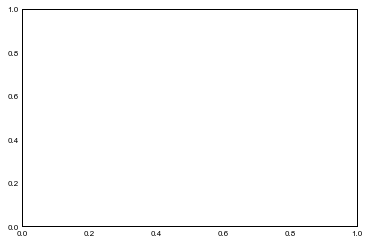

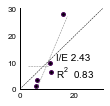

79.89190348478172
c2_EI 170510
2
2
2
2
2


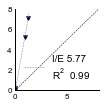

55.49284656484512
c3_EI 170524
c1_EI 170524
c2_EI 170530
1
1
2
2
1
1
2
1
2
2


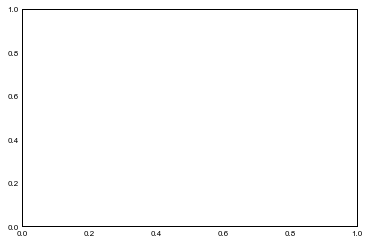

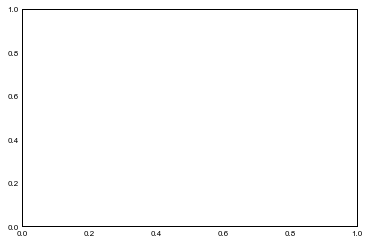

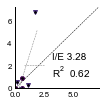

70.35389569571599
c1_EI 170530
1
1
2
2
1
1
2
1
2
2


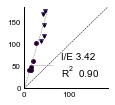

198.33809693430769
c2_EI 170531
c4_EI 170531
c1_EI 170531
1
1
2
2
1
1
2
1
2
2


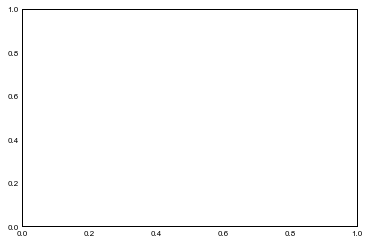

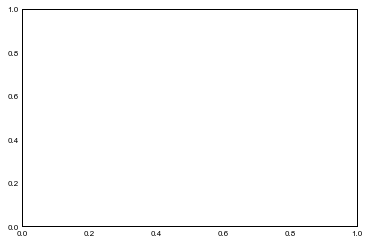

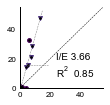

580.1148691065638
c5_EI 170720
2
2
2
2
2


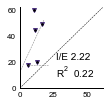

54.03636367952714
c3_EI 170720
2
2
2
2
2


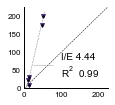

205.90539404089233
c4_EI 170720
2
2
2
2
2


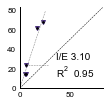

93.54859161711
c2_EI 170720
1
1
2
2
1
1
2
1
2
2


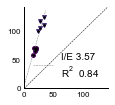

121.8553343995456
Number of neurons is 9


In [9]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import math
from matplotlib import mlab

feature = 1
areaScalingFactor = 1e9 # nA.ms
scalingFactor = areaScalingFactor
r_squared = []
slopes = []
valid_neurons = []
studentised_res = []
coord_sqr_all_cells = []
fig2, ax2 = plt.subplots()
for index, n in enumerate(neurons):
    n = neurons[index]
    print(n.index, n.date)
#     print (n.features)
    obs_exc, obs_inh = {}, {}
    exc_error, inh_error = {}, {}
    amplitude = {}
    sqrs = []
    coord_sqrs = {}
    fig, ax = plt.subplots()
    # fig.suptitle("Representative cell {}, {}".format(n.index,n.date), fontsize=18)
    for expType,expt in n:
        for sqr in expt:
            if sqr == 1 or sqr == 2:
                if (expType == 1):
                    sqrs.append(sqr)
                    for coord in expt[sqr].coordwise:
                        obs_exc[coord] = expt[sqr].coordwise[coord].average_feature[feature]
                        exc_error[coord] = np.var([trial.feature[feature] for trial in expt[sqr].coordwise[coord].trials], ddof = 1)
                        amplitude[coord] = -expt[sqr].coordwise[coord].average_feature[5]
                        coord_sqrs[coord] = sqr
                elif (expType == 2):
                    for coord in expt[sqr].coordwise:
                        obs_inh[coord] = expt[sqr].coordwise[coord].average_feature[feature]
                        inh_error[coord] = np.var([trial.feature[feature] for trial in expt[sqr].coordwise[coord].trials], ddof = 1)

    if len(set(obs_exc).intersection(set(obs_inh))):
        exc, inh = [], []
        amp = []
        marker = {1:'o', 2:'v'}
        coord_sqr = []
        for coord in set(obs_exc).intersection(set(obs_inh)):
            exc.append(-obs_exc[coord]*scalingFactor)
            inh.append(obs_inh[coord]*scalingFactor)
            amp.append(amplitude[coord]*scalingFactor)
            coord_sqr.append(coord_sqrs[coord])
            ax.errorbar(-obs_exc[coord]*scalingFactor, obs_inh[coord]*scalingFactor, xerr=exc_error[coord]*scalingFactor, yerr=inh_error[coord]*scalingFactor,markersize=3, c='k', fmt='.', alpha=1, markerfacecolor='k', ecolor='gray')
            ax.scatter(-obs_exc[coord]*scalingFactor, obs_inh[coord]*scalingFactor, c=color_sqr[coord_sqrs[coord]], s=15, marker=marker[coord_sqrs[coord]])
            print(coord_sqrs[coord])
            valid_neurons.append(n.date + '_' + n.index)

        slope, intercept, rval, pval, stderr = ss.linregress(exc, inh)

        excRange = np.linspace(0, 1.1*max(exc), 100)
        inhFit = excRange*slope + intercept

        r_squared.append(rval**2)
        slopes.append(slope)

        ax.plot(excRange, inhFit, '--', c='gray', label="I/E {:.2f}\n".format(slope) + "$\mathregular{R^2}$ " + " {:.2f}".format(rval**2))

        xlim_old = ax.get_xlim()
        ylim_old = ax.get_ylim()
        minlim, maxlim = min(xlim_old[0], ylim_old[0]), max(xlim_old[1], ylim_old[1])
        ax.plot((0,maxlim), (0,maxlim),'--')
        ax.set_xlim(0,maxlim)
        ax.set_ylim(0,maxlim)
#         ax.set_xlabel("Excitation (nA.ms)")
#         ax.set_ylabel("Inhibition (nA.ms)")
#         ax.set_xlabel("Excitation (pA)")
#         ax.set_ylabel("Inhibition (pA)")
        fig.set_figheight(1.5)
        fig.set_figwidth(1.5)
        simpleaxis(ax)
        ax.legend(loc='lower right')
        dump(fig,file('figures/fig2/2_oneSq_{}_{}.pkl'.format(n.index, n.date),'wb'))
        plt.show()
        plt.close(fig)
#         plt.savefig("/media/sahil/NCBS_Shares_BGStim/Paper/EI_figures_Aug9/{}_{}.svg".format(n.date,n.index) , transparent=True, bbox_inches='tight')
        
        
        predicted = slope*np.array(exc) + intercept
        actual = inh
        residual = actual - predicted       
#         ax2.scatter(amp, residual/np.std(predicted) ,s=5,c=color_cell[index])
        ax2.scatter(amp, residual/np.std(residual,ddof=1) ,s=3,c=[color_sqr[i] for i in coord_sqr])
        studentised_res.append(residual/np.std(residual,ddof=1))
        coord_sqr_all_cells.append(coord_sqr)
        print( np.max(amp))
        
ax2.set_xscale('log')
ax2.set_ylabel("Standardized residuals")
ax2.set_xlabel("Amplitude (pA)")
xmin, xmax = ax2.get_xlim()
ymin,ymax = -3,3
ax2.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
# ax2.set_ylim(ymin, ymax)
# ax2.set_xlim(0, 100)
ax2.hlines(y=0, xmin=xmin, xmax = xmax,linestyles='--')
# ax2.set_xlabel("Area under curve (pA)")
ax2.get_xaxis().tick_bottom()
divider = make_axes_locatable(ax2)
axHisty = divider.append_axes("right", 1.2, pad=0.1, sharey=ax2)

# make some labels invisible
plt.setp(axHisty.get_yticklabels(),
         visible=False)

# now determine nice limits by hand:
# binwidth = 0.25
# xymax = np.max([np.max(np.fabs(x)), np.max(np.fabs(y))])
# lim = (int(xymax/binwidth) + 1)*binwidth

# bins = np.arange(-lim, lim + binwidth, binwidth)
# axHistx.hist(x, bins=bins)
list_res = np.concatenate(studentised_res).ravel()
list_coords = np.concatenate(coord_sqr_all_cells).ravel()

res_square = []
color_square = []
for i in sorted(list(set(list_coords))):
    res_square.append(list_res[np.where(list_coords == i)])
    color_square.append(color_sqr[i])

res_hist = axHisty.hist(res_square, bins=20, orientation='horizontal', stacked=True, color=color_square)
axHisty.yaxis.set_visible(True)

mu = 0
variance = 1
sigma = math.sqrt(variance)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, len(list_coords))

dx = res_hist[1][1] - res_hist[1][0]
scale = len(list_res)*dx


axHisty.plot(mlab.normpdf(x, mu, sigma)*scale,x, '--',color='red')
axHisty.set_xlabel("# PSCs")

# the xaxis of axHistx and yaxis of axHisty are shared with axScatter,
# thus there is no need to manually adjust the xlim and ylim of these
# axis.

#axHistx.axis["bottom"].major_ticklabels.set_visible(False)
# for tl in axHistx.get_xticklabels():
#     tl.set_visible(False)
# axHistx.set_yticks([0, 50, 100])

simpleaxis(ax2)
simpleaxis(axHisty,every=True)
axHisty.spines['bottom'].set_visible(True)

fig2.set_figheight(1.5)
fig2.set_figwidth(3.5)
# plt.show(fig2)
plt.savefig('figures/fig2/2_temp.svg', transparent=True, bbox_inches='tight')
print ("Number of neurons is {}".format(len(set(valid_neurons))))

[6.66881869e-10 5.04447377e-10 1.06942594e-09 2.50946046e-09
 3.34977981e-10 2.04297467e-10 4.22047287e-10 1.29722812e-09
 8.49708716e-10 1.89419827e-10]


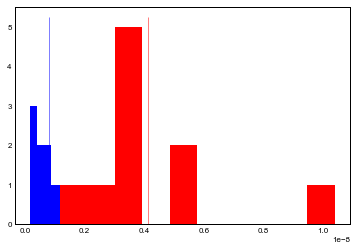

pFail: E_mean= 8.04789504326e-10, I_mean = 4.13928138922e-09


In [10]:
fig, ax = plt.subplots()
exc, inh = [], []
exc_e, inh_e = [], []
fail_e, fail_i = [], []
amp = []
coord_sqr = []
for coord in set(obs_exc).intersection(set(obs_inh)):
    exc.append(-obs_exc[coord])#*scalingFactor)
    inh.append(obs_inh[coord])#*scalingFactor)
    inh_e.append(inh_error[coord])#*scalingFactor)
    exc_e.append(exc_error[coord])#*scalingFactor)
fail_e = np.array(exc_e)/np.array(exc)
fail_i = np.array(inh_e)/np.array(inh)
print (fail_e)
ax.hist(fail_e, color='b') #, s=15)
ax.hist(fail_i, color='r') #, s=15)
ymin,ymax = ax.get_ylim()
ax.vlines(x=np.mean(fail_e),ymin=ymin,ymax=ymax,color='b')
ax.vlines(x=np.mean(fail_i),ymin=ymin,ymax=ymax,color='r')
ax.set_ylim(ymin=0)
plt.show()
print("pFail: E_mean= {}, I_mean = {}".format(np.mean(fail_e), np.mean(fail_i)))

In [11]:
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

## Polar coordinates

No handlers could be found for logger "matplotlib.legend"


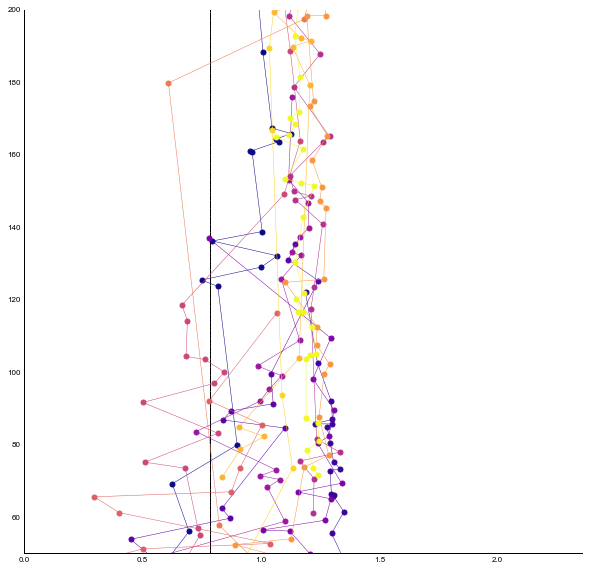

In [12]:
feature = 1
scalingFactor = 1e9
# r_squared = []
# slopes = []
fig, ax = plt.subplots()
for index, n in enumerate(neurons):
    n = neurons[index]
    obs_exc, obs_inh = {}, {}
    exc_error, inh_error = {}, {}
    sqrs = []

    # fig.suptitle("Representative cell {}, {}".format(n.index,n.date), fontsize=18)
    for expType,expt in n:
        for sqr in expt:
            if (expType == 1):
                sqrs.append(sqr)
                for coord in expt[sqr].coordwise:
                    obs_exc[coord] = expt[sqr].coordwise[coord].average_feature[5]
                    exc_error[coord] = np.std([trial.feature[5] for trial in expt[sqr].coordwise[coord].trials], ddof = 1)
            elif (expType == 2):
                for coord in expt[sqr].coordwise:
                    obs_inh[coord] = expt[sqr].coordwise[coord].average_feature[0]
                    inh_error[coord] = np.std([trial.feature[0] for trial in expt[sqr].coordwise[coord].trials], ddof = 1)

    exc, inh = [], []
    for coord in set(obs_exc).intersection(set(obs_inh)):
        exc.append(-obs_exc[coord])
        inh.append(obs_inh[coord])
        #ax.errorbar(-obs_exc[coord]*scalingFactor, obs_inh[coord]*scalingFactor, xerr=exc_error[coord]*scalingFactor, yerr=inh_error[coord]*scalingFactor,markersize=3, c='k', fmt='.', alpha=1, markerfacecolor='k', ecolor='gray')
    exc, inh = np.array(exc), np.array(inh)
#     axisMax = np.max([np.max(exc), np.max(inh)])
    axisMax = 1e-9
    exc , inh = exc/axisMax, inh/axisMax
    indices = np.argsort(exc)
    exc = exc[indices]
    inh = inh[indices]
    r, theta = cart2pol(exc, inh)
    ax.plot(theta, exc, '.-', color=color_cell[index])
    ax.set_xlim(0,0.75*np.pi)
#     ax.set_ylim(ymin=5.)
    ax.vlines(x=0.785,ymin=0.,ymax=200.,linestyles='--')
    ax.set_ylim(50.,200)
#     slope, intercept, rval, pval, stderr = ss.linregress(exc, inh)
#     excRange = np.linspace(0, 1.1*max(exc), 100)
#     inhFit = excRange*slope + intercept
    
#     r_squared.append(rval**2)
#     slopes.append(slope)
    
#     ax.plot(excRange, inhFit, '--', c='gray', label="slope {:.2f}, $r^2$ {:.2f}".format(slope, rval**2))

#     xlim_old = ax.get_xlim()
#     ylim_old = ax.get_ylim()
#     minlim, maxlim = min(xlim_old[0], ylim_old[0]), max(xlim_old[1], ylim_old[1])
#     ax.plot((0,maxlim), (0,maxlim),'--')
#     ax.set_xlim(0,maxlim)
#     ax.set_ylim(0,maxlim)
#     ax.set_xlabel("Excitation (pA)")
#     ax.set_ylabel("Inhibition (pA)")
fig.set_figheight(10)
fig.set_figwidth(10)
simpleaxis(ax)
plt.legend(loc='lower right')
plt.show()
#plt.savefig("/media/sahil/NCBS_Shares_BGStim/EI_figures_Aug9/{}_{}.png".format(n.date,n.index))
plt.close()

## Figure 2 C (Example Cell)

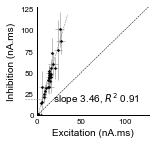

In [13]:
index = 8
feature = 1
n = neurons[index]
obs_exc, obs_inh = {}, {}
exc_error, inh_error = {}, {}
sqrs = []
fig, ax = plt.subplots()
# fig.suptitle("Representative cell {}, {}".format(n.index,n.date), fontsize=18)
for expType,expt in n:
    for sqr in expt:
        if (expType == 1):
            sqrs.append(sqr)
            for coord in expt[sqr].coordwise:
                obs_exc[coord] = expt[sqr].coordwise[coord].average_feature[feature]
                exc_error[coord] = np.std([trial.feature[feature] for trial in expt[sqr].coordwise[coord].trials], ddof = 1)
        elif (expType == 2):
            for coord in expt[sqr].coordwise:
                obs_inh[coord] = expt[sqr].coordwise[coord].average_feature[feature]
                inh_error[coord] = np.std([trial.feature[feature] for trial in expt[sqr].coordwise[coord].trials], ddof = 1)

exc, inh = [], []
for coord in set(obs_exc).intersection(set(obs_inh)):
    exc.append(-obs_exc[coord]*scalingFactor)
    inh.append(obs_inh[coord]*scalingFactor)
    ax.errorbar(-obs_exc[coord]*scalingFactor, obs_inh[coord]*scalingFactor, xerr=exc_error[coord]*scalingFactor, yerr=inh_error[coord]*scalingFactor,markersize=3, c='k', fmt='.', alpha=1, markerfacecolor='k', ecolor='gray')

slope, intercept, rval, pval, stderr = ss.linregress(exc, inh)

excRange = np.linspace(0, 1.3*max(exc), 100)
inhFit = excRange*slope + intercept

ax.plot(excRange, inhFit, '--', c='gray', label="slope {:.2f}, $R^2$ {:.2f}".format(slope, rval**2))

xlim_old = ax.get_xlim()
ylim_old = ax.get_ylim()
minlim, maxlim = min(xlim_old[0], ylim_old[0]), max(xlim_old[1], ylim_old[1])
ax.plot((0,maxlim), (0,maxlim),'--')
ax.set_xlim(0,maxlim)
ax.set_ylim(0,maxlim)
ax.set_xlabel("Excitation (nA.ms)")
ax.set_ylabel("Inhibition (nA.ms)")
fig.set_figheight(2)
fig.set_figwidth(2)
simpleaxis(ax)
plt.legend(loc='lower right')
# dump(fig,file('figures/fig2/2c.pkl','wb'))
plt.show()

## Only one square and two square

NameError: name 'line_exc1' is not defined

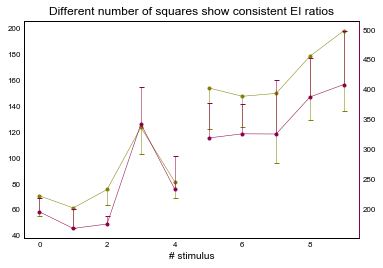

In [14]:
index = 5
feature = 1
n = neurons[index]
obs_exc, obs_inh = {}, {}
exc_error, inh_error = {}, {}
sqrs = []
# fig, ax = plt.subplots()
# fig.suptitle("Representative cell {}, {}".format(n.index,n.date), fontsize=18)
areaScalingFactor = 1e9 # nA.ms
for expType,expt in n:
    for sqr in expt:
        if sqr in [1,2,3]:
            if (expType == 1):
                sqrs.append(sqr)
                for coord in expt[sqr].coordwise:
                    obs_exc[coord] = expt[sqr].coordwise[coord].average_feature[5]*areaScalingFactor
                    exc_error[coord] = np.std([trial.feature[5]*areaScalingFactor for trial in expt[sqr].coordwise[coord].trials], ddof = 1)
            elif (expType == 2):
                for coord in expt[sqr].coordwise:
                    obs_inh[coord] = expt[sqr].coordwise[coord].average_feature[0]*areaScalingFactor
                    inh_error[coord] = np.std([trial.feature[0]*areaScalingFactor for trial in expt[sqr].coordwise[coord].trials], ddof = 1)

exc, inh = [], []
coord_len = []
exc_e, inh_e = [], []
for coord in set(obs_exc).intersection(set(obs_inh)):
    exc.append(-obs_exc[coord])
    inh.append(obs_inh[coord])
    coord_len.append(len(coord))
    exc_e.append(exc_error[coord])
    inh_e.append(inh_error[coord])
#     ax.errorbar(-obs_exc[coord]*scalingFactor, obs_inh[coord]*scalingFactor, xerr=exc_error[coord]*scalingFactor, yerr=inh_error[coord]*scalingFactor,markersize=3, c='k', fmt='.', alpha=1, markerfacecolor='k', ecolor='gray')

coord_len = np.array(coord_len)
exc = np.array(exc)
inh = np.array(inh)
exc_e = np.array(exc_e)
inh_e = np.array(inh_e)

index_1 = np.where(coord_len==1)
exc_1 = exc[index_1]
inh_1 = inh[index_1]
exc_1_e = exc_e[index_1]
inh_1_e = inh_e[index_1]

index_2 = np.where(coord_len==2)
exc_2 = exc[index_2]
inh_2 = inh[index_2]
exc_2_e = exc_e[index_2]
inh_2_e = inh_e[index_2]

index_3 = np.where(coord_len==3)
exc_3 = exc[index_3]
inh_3 = inh[index_3]

fig, ax = plt.subplots()
plotline1, caplines1, barlinecols1  = ax.errorbar(np.arange(len(exc_1)), exc_1,  yerr = exc_1_e , markersize=6, label="Exc",c='olive', fmt='.-', uplims=True)
plotline2, caplines2, barlinecols2 = ax.errorbar(len(exc_1) + np.arange(len(exc_2)), exc_2,  yerr = exc_2_e, markersize=6 ,c='olive', fmt='.-', uplims=True)
# line_exc3 = ax.plot(len(exc_1) + len(exc_2) + np.arange(len(exc_3)), exc_3, '.-', markersize=6 ,c=color_sqr[3])

# ax.xaxis.set_ticks([1,3,5,7,9])
ax_copy = ax.twinx()
plotline3, caplines3, barlinecols3  = ax_copy.errorbar( np.arange(len(inh_1)), inh_1,  yerr = inh_1_e, markersize=6, label="Inh",c='#8b0046', fmt='.-', lolims=True)
plotline4, caplines4, barlinecols4  = ax_copy.errorbar( len(inh_1) + np.arange(len(inh_2)), inh_2,  yerr = inh_2_e, markersize=6 ,c='#8b0046', fmt='.-', lolims=True)
# line_inh3 = ax_copy.plot( len(inh_1) + len(inh_2) + np.arange(len(inh_3)), inh_3, 'v-', markersize=6 ,c=color_sqr[3])
ax.set_title("Different number of squares show consistent EI ratios")
ax.set_xlabel("# stimulus")

caplines1[0].set_marker('_')
caplines1[0].set_markersize(5)
caplines2[0].set_marker('_')
caplines2[0].set_markersize(5)
caplines3[0].set_marker('_')
caplines3[0].set_markersize(5)
caplines4[0].set_marker('_')
caplines4[0].set_markersize(5)

ax.spines['left'].set_color('olive')
ax_copy.spines['right'].set_color('#8b0046')
lines = line_exc1 + line_exc2 + line_inh1 + line_inh2
# labs = [l.get_label() for l in lines]
# ax.legend(lines, labs, loc=0)

simpleaxis(ax)
simpleaxis(ax_copy,every=True)
ax_copy.spines['right'].set_visible(True)
ax_copy.get_yaxis().tick_right()

ax.set_ylim(ymin=0., ymax=206.)
ax_copy.set_ylim(ymin=0., ymax=515.)

ax.set_yticks(np.linspace(0,206.,3))
ax_copy.set_yticks(np.linspace(0,516.,3))

ax.set_ylabel("Excitation (pA)")
ax_copy.set_ylabel("Inhibition (pA)")

fig.set_figheight(1.5)
fig.set_figwidth(3.)

dump(fig,file('figures/fig2/2_precise_small.pkl','wb'))
plt.savefig('figures/fig2/2_precise_small.svg')
plt.show()
#ax.set_ylabel("$r^2$ values")
# ax_copy.set_ylim((0.1,10))
print(ax.get_ylim())
print(ax_copy.get_ylim())
# ax_copy.set_yscale("log")

print(index_1)

In [ ]:
exc

### Plotting residuals

In [ ]:
predicted = slope*np.array(exc) + intercept
actual = inh
residual = actual - predicted
fig, ax = plt.subplots()
ax.scatter(predicted, residual,s=20)
xmin, xmax = ax.get_xlim()
ax.hlines(y=0, xmin=xmin, xmax = xmax,linestyles='--')
ax.set_ylim(-30,30)
simpleaxis(ax)
plt.show()

## Figure F (I/E ratio) Population

In [ ]:
fig, ax = plt.subplots()
ax.hist(slopes)
ax.set_xlabel("I/E Ratio")
ax.set_ylabel("# neurons")
ax.set_xlim(xmin=0.)
ax.set_xticks([0,2,4,6])
# ax.set_yticks([0,1,2])
fig.set_figheight(1.5)
fig.set_figwidth(1.5)
simpleaxis(ax)
dump(fig,file('figures/fig2/2f.pkl','wb'))
plt.show()

## Figure G (r-squared) Population

In [ ]:
fig, ax = plt.subplots()
ax.hist(r_squared)
# ax[0].set_title("$r^2$ for linear regression")
ax.set_xlabel("$R^2$")
ax.set_ylabel("# neurons")
ax.set_xlim(xmin=0., xmax=1)
fig.set_figheight(1.5)
fig.set_figwidth(1.5)
simpleaxis(ax)
dump(fig,file('figures/fig2/2g_oneSq.pkl','wb'))
plt.show()

In [15]:
np.mean(r_squared), np.std(r_squared,ddof=1)

(0.8002346820840309, 0.24627777523205255)

In [16]:
r_squared

[0.8262996922771971,
 0.994965141091018,
 0.6245336974347766,
 0.9020256958902456,
 0.854792020016494,
 0.21506129639994828,
 0.9854464325226124,
 0.954164521293694,
 0.8448236418302931]

In [17]:
n.features

{0: 'epsp_max',
 1: 'epsp_area',
 2: 'epsp_avg',
 3: 'epsp_time_to_peak',
 4: 'epsp_area_to_peak',
 5: 'epsp_min',
 6: 'epsp_onset'}

## Figure 2 (D): r-square and (E): I/E changes with number of squares

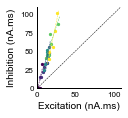

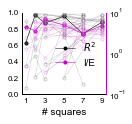

In [13]:
slopes = []
index = 8
n = neurons[index]
obs_exc, obs_inh = {}, {}
sqrs = {}
feature = 1

fig, ax = plt.subplots()
# f.suptitle("Representative cell {}, {}".format(n.index,n.date), fontsize=18)

r_sqrs, slopes, sqrs = [], [], []

for sqr in set(n.experiment[1]).intersection(set(n.experiment[2])):
    exc, inh = [], []
    exc_error, inh_error = [], []
    for coord in set(n.experiment[1][sqr].coordwise).intersection(set(n.experiment[1][sqr].coordwise)):
        exc.append(-n.experiment[1][sqr].coordwise[coord].average_feature[feature]*scalingFactor)
        inh.append(n.experiment[2][sqr].coordwise[coord].average_feature[feature]*scalingFactor)
        exc_error.append(np.std([trial.feature[feature] for trial in n.experiment[1][sqr].coordwise[coord].trials], ddof = 1)*scalingFactor)
        inh_error.append(np.std([trial.feature[feature] for trial in n.experiment[2][sqr].coordwise[coord].trials], ddof = 1)*scalingFactor)
    ax.scatter(exc, inh, c=color_sqr[sqr], s=5, label=sqr)
    #ax[0].errorbar(exc, inh, xerr=exc_error, yerr=inh_error, c='k', fmt='.', alpha=0.1)

    slope, intercept, rval, pval, stderr = ss.linregress(exc, inh)

    excRange = np.linspace(0.9*min(exc), 1.1*max(exc), 100)
    inhFit = excRange*slope + intercept

    ax.plot(excRange, inhFit, '--', c=color_sqr[sqr])
    sqrs.append(sqr)
    slopes.append(slope)
    r_sqrs.append(rval**2)

xlim_old = ax.get_xlim()
ylim_old = ax.get_ylim()
minlim, maxlim = min(xlim_old[0], ylim_old[0]), max(xlim_old[1], ylim_old[1])
ax.plot((0,maxlim), (0,maxlim),'--', label="P=1")
ax.set_xlim(0,maxlim)
ax.set_ylim(0,maxlim)
ax.set_title("Linear regression showing proportional E and I")
ax.set_xlabel("Excitation (nA.ms)")
ax.set_ylabel("Inhibition (nA.ms)")
#ax.legend(loc='lower right')
fig.set_figheight(1.5)
fig.set_figwidth(1.5)
simpleaxis(ax)
dump(fig,file('figures/fig2/2d.pkl','wb'))
plt.show()

fig, ax = plt.subplots()
line1 = ax.plot(sqrs, r_sqrs, '.-', markersize=6, label="$R^2$",c='k')
ax.set_ylim((0,1))
ax.xaxis.set_ticks([1,3,5,7,9])
ax_copy = ax.twinx()
line2 = ax_copy.plot(sqrs, slopes, '.-', markersize=6, label="I/E",c='m')
ax.set_title("Different number of squares show consistent EI ratios")
ax.set_xlabel("# squares")
#ax.set_ylabel("$r^2$ values")
ax_copy.set_ylim((0.1,10))
#ax_copy.set_ylabel("E/I Ratio (P)")
ax_copy.set_yscale("log")


for index, n in enumerate(neurons):
    n = neurons[index]
    r_sqrs, slopes, sqrs = [], [], []
    for sqr in set(n.experiment[1]).intersection(set(n.experiment[2])):
        exc, inh = [], []
        exc_error, inh_error = [], []
        for coord in set(n.experiment[1][sqr].coordwise).intersection(set(n.experiment[1][sqr].coordwise)):
            exc.append(-n.experiment[1][sqr].coordwise[coord].average_feature[feature]*scalingFactor)
            inh.append(n.experiment[2][sqr].coordwise[coord].average_feature[feature]*scalingFactor)
            exc_error.append(np.std([trial.feature[feature] for trial in n.experiment[1][sqr].coordwise[coord].trials], ddof = 1)*scalingFactor)
            inh_error.append(np.std([trial.feature[feature] for trial in n.experiment[2][sqr].coordwise[coord].trials], ddof = 1)*scalingFactor)
            
        slope, intercept, rval, pval, stderr = ss.linregress(exc, inh)

        sqrs.append(sqr)
        slopes.append(slope)
        r_sqrs.append(rval**2)
    
    ax.plot(sqrs, r_sqrs, '.-', markersize=6,c='k', alpha=0.2, markerfacecolor='w')
    ax_copy.plot(sqrs, slopes, '.-', markersize=6, c='m', alpha=0.2, markerfacecolor='w')
    
ax.spines['left'].set_color('k')
ax_copy.spines['right'].set_color('m')
lines = line1+line2
labs = [l.get_label() for l in lines]
ax.legend(lines, labs, loc=0)
fig.set_figheight(1.5)
fig.set_figwidth(1.5)
simpleaxis(ax)
simpleaxis(ax_copy,every=True)
ax_copy.spines['right'].set_visible(True)
ax_copy.get_yaxis().tick_right()

dump(fig,file('figures/fig2/2e.pkl','wb'))
plt.show()

    A. shows tight balance between tight balance between excitation and inhibition at the CA1 neuron. 
    B. shows r-square for linear regression showing high degree of correlation between E and I. 
    C. showing different proportionality P of all CA1 neurons.